In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score 

In [13]:
file= r'c:\users\senvo\downloads\Task 3 and 4_Loan_Data.csv' 

In [14]:
loan =pd.read_csv(file)

In [15]:
loan.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


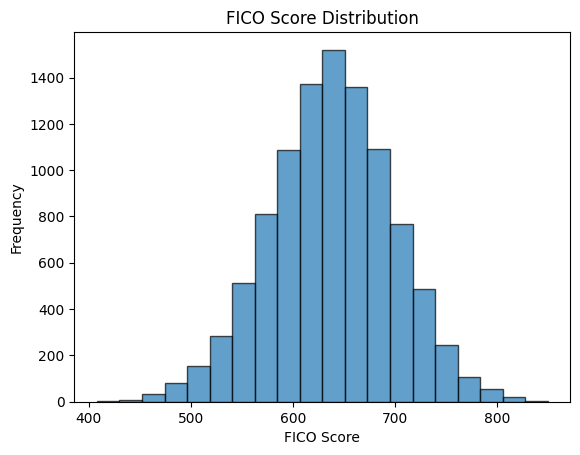

In [16]:
## checking the fico_scores distribution
plt.hist(loan['fico_score'], bins=20, edgecolor='k', alpha=0.7)
plt.title('FICO Score Distribution')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()

In [18]:
## The idea here is to implement a method to bucket the FICO scores such that the MSE within each bucket is minimized.

In [19]:
def mse_bucketing(scores, n_buckets):
    scores = np.sort(scores)
    buckets = np.array_split(scores, n_buckets)
    boundaries = [bucket[-1] for bucket in buckets[:-1]]
    return boundaries

# Apply the bucketing method
n_buckets = 5
buckets_mse = mse_bucketing(loan['fico_score'].values, n_buckets)
print("Bucket boundaries (MSE):", buckets_mse)


Bucket boundaries (MSE): [np.int64(587), np.int64(623), np.int64(653), np.int64(688)]


In [20]:
## Here we also use this method to bucket the FICO scores to maximize the log-likelihood function.

In [22]:
from scipy.optimize import minimize

In [23]:
def log_likelihood_bucketing(loan, n_buckets):
    scores = loan['fico_score'].values
    defaults = loan['default'].values
    total_records = len(scores)
    
    def log_likelihood(boundaries):
        boundaries = np.sort(boundaries)
        n_records = np.zeros(n_buckets)
        n_defaults = np.zeros(n_buckets)
        
        boundaries = [min(scores) - 1] + list(boundaries) + [max(scores) + 1]
        
        for i in range(total_records):
            for j in range(1, n_buckets + 1):
                if boundaries[j-1] < scores[i] <= boundaries[j]:
                    n_records[j-1] += 1
                    if defaults[i] == 1:
                        n_defaults[j-1] += 1
                    break
        
        p = n_defaults / n_records
        ll = np.sum(n_defaults * np.log(p + 1e-9) + (n_records - n_defaults) * np.log(1 - p + 1e-9))
        return ll
    
    initial_boundaries = np.linspace(min(scores), max(scores), n_buckets+1)[1:-1]
    result = minimize(lambda x: -log_likelihood(x), initial_boundaries, method='L-BFGS-B', bounds=[(min(scores), max(scores))] * (n_buckets - 1))
    return result.x

### Number of buckets
n_buckets = 5

### Apply the bucketing method
buckets_log_likelihood = log_likelihood_bucketing(loan, n_buckets)
buckets_log_likelihood


array([496.4, 584.8, 673.2, 761.6])

In [ ]:
## dynamic programming approach to optimize the bucket boundaries

In [24]:
def dp_bucketing(scores, defaults, n_buckets):
   
    pass

## Apply the bucketing method
buckets_dp = dp_bucketing(loan['fico_score'].values, loan['default'].values, n_buckets)
print("Bucket boundaries (Dynamic Programming):", buckets_dp)


Bucket boundaries (Dynamic Programming): None


In [25]:

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Define the bucketing function
def log_likelihood_bucketing(loan, n_buckets):
    scores = loan['fico_score'].values
    defaults = loan['default'].values
    total_records = len(scores)
    
    def log_likelihood(boundaries):
        boundaries = np.sort(boundaries)
        n_records = np.zeros(n_buckets)
        n_defaults = np.zeros(n_buckets)
        
        boundaries = [min(scores) - 1] + list(boundaries) + [max(scores) + 1]
        
        for i in range(total_records):
            for j in range(1, n_buckets + 1):
                if boundaries[j-1] < scores[i] <= boundaries[j]:
                    n_records[j-1] += 1
                    if defaults[i] == 1:
                        n_defaults[j-1] += 1
                    break
        
        p = n_defaults / n_records
        ll = np.sum(n_defaults * np.log(p + 1e-9) + (n_records - n_defaults) * np.log(1 - p + 1e-9))
        return ll
    
    initial_boundaries = np.linspace(min(scores), max(scores), n_buckets+1)[1:-1]
    result = minimize(lambda x: -log_likelihood(x), initial_boundaries, method='L-BFGS-B', bounds=[(min(scores), max(scores))] * (n_buckets - 1))
    return result.x

# Number of buckets
n_buckets = 5

# Apply the bucketing method
buckets_log_likelihood = log_likelihood_bucketing(loan, n_buckets)

# Define the function to categorize FICO scores into buckets
def categorize_fico_score(fico_score, boundaries):
    for i, boundary in enumerate(boundaries):
        if fico_score <= boundary:
            return i
    return len(boundaries)

# Categorize FICO scores for the existing data
loan['fico_bucket'] = loan['fico_score'].apply(lambda x: categorize_fico_score(x, buckets_log_likelihood))

# Features and target variable
X = loan[['fico_bucket']]
y = loan['default']

# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the probability of default for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, model.predict(X_test))
roc_auc = roc_auc_score(y_test, y_pred_proba)

# data for prediction
new_data = pd.DataFrame({
    'fico_score': [510, 620, 700, 480, 760]
})

# Categorize FICO scores for the new data
new_data['fico_bucket'] = new_data['fico_score'].apply(lambda x: categorize_fico_score(x, buckets_log_likelihood))

# Predict the probability of default for the new data
new_data['probability_of_default'] = model.predict_proba(new_data[['fico_bucket']])[:, 1]

accuracy, roc_auc, new_data


(0.821,
 np.float64(0.6886610843972807),
    fico_score  fico_bucket  probability_of_default
 0         510            1                0.391885
 1         620            2                0.169682
 2         700            3                0.060861
 3         480            0                0.670201
 4         760            3                0.060861)

In [27]:
##Model Interpretation
#The goal of this model is to predict the probability of default (PD) for loan applicants based on their FICO scores
#The model was achieved through the processes below:

##step:1
#Bucketing FICO Scores:

# Log-Likelihood Bucketing: The FICO scores are divided into discrete buckets to capture the relationship between score ranges and 
# default probability. The log-likelihood method was used to find the optimal boundaries, which aim to maximize the distinction between default probabilities across buckets.
# Optimal Boundaries: The optimal boundaries determined by this method were used to categorize the FICO scores into 5 buckets.

##step:2
## Training the Model:
##Data Preparation: The FICO scores of the given dataset were categorized into the buckets based on the derived boundaries.
## Model Selection: A logistic regression model was chosen to predict the probability of default.
## Model Training: The model was trained on the categorized FICO scores and default labels, with the data split into training and test sets using stratified sampling to maintain the class distribution.

##step3: Model Evaluation
## Accuracy: The model achieved an accuracy of 82%, meaning it correctly predicted whether a customer would default or not in 82% of cases.
## ROC AUC: The ROC AUC score was 0.69, indicating a fair ability to distinguish between defaulters and non-defaulters. A score of 0.69 suggests that the model has room for improvement but is better than random guessing (0.5).

##step:4
##Prediction on of Defaulters:

## The model was used to predict the probability of default for new customers based on their FICO scores.
## The predictions show varying probabilities of default across different FICO score ranges:
## Lower FICO scores (e.g., 480) have a higher probability of default (67%).
## Higher FICO scores (e.g., 700 and 760) have a much lower probability of default (around 6%).
## Intermediate scores (e.g., 510 and 620) show moderate probabilities of default (39% and 17%).